# Creating sequential base model for text generation

This base model would try to predict text, treating it as a sequence of words.

Based on amazon food reviews, base model should be able to reproduce (at least, get close to) those reviews with sklearn algorithms.

## Load and analyze data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from tqdm import tqdm
from src.text_preprocessor import TextPreprocessor

tqdm.pandas()

reviews_df = pd.read_csv('../amazon-food-reviews.csv')
reviews_df.columns = [col_name.lower() for col_name in reviews_df.columns]
reviews_df = reviews_df[['text']]
reviews_df = reviews_df.drop_duplicates(subset=['text'])
reviews_df = reviews_df.dropna()
reviews_df.head()

text
0  I have bought several of the Vitality canned d...
1  Product arrived labeled as Jumbo Salted Peanut...
2  This is a confection that has been around a fe...
3  If you are looking for the secret ingredient i...
4  Great taffy at a great price.  There was a wid...

In [3]:
text_preprocessor = TextPreprocessor(lemmatization=False)

reviews_df['text'] = reviews_df['text'].progress_apply(text_preprocessor.process)
reviews_df['wc'] = reviews_df['text'].progress_apply(lambda x: len([word for word in x.split(' ') if word != '']))
reviews_df.describe()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 393579/393579 [00:02<00:00, 183845.48it/s]


wc
count  393579.000000
mean       44.132156
std        45.283719
min         0.000000
25%        18.000000
50%        30.000000
75%        53.000000
max      2092.000000

In [4]:
from sklearn.ensemble import IsolationForest

wc_isolation_forest = IsolationForest(contamination=0.2)

wc_vector = reviews_df['wc'].to_numpy().reshape((-1, 1))
print('Fitting...')
wc_isolation_forest.fit(wc_vector)

print('Predicting...')
outlier_mask = wc_isolation_forest.predict(wc_vector)
outlier_idx = outlier_mask == -1

filtered_reviews_df = reviews_df[~outlier_idx]
filtered_reviews_df.describe()

Fitting...
Predicting...


wc
count  316435.000000
mean       31.007610
std        15.687982
min        11.000000
25%        18.000000
50%        27.000000
75%        41.000000
max        74.000000

<AxesSubplot:>

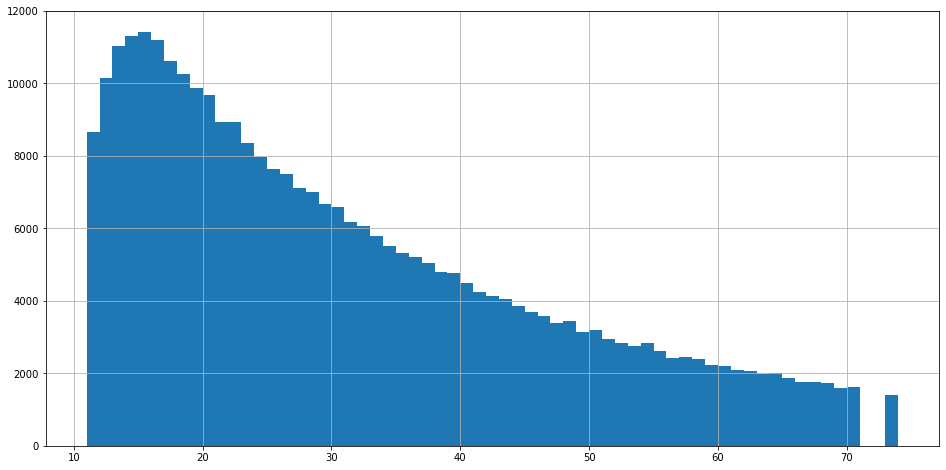

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

filtered_reviews_df['wc'].hist(bins=63, figsize=(16,8))

## Prepare data for training

<AxesSubplot:>

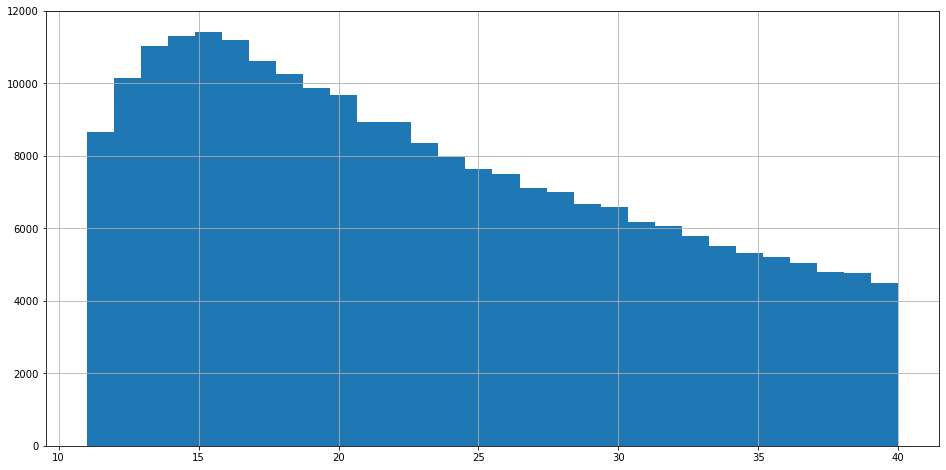

In [13]:
# Debug only!
max_word_count_forced = 41
filtered_reviews_df = filtered_reviews_df[filtered_reviews_df['wc'] < max_word_count_forced]
filtered_reviews_df['wc'].hist(bins=30, figsize=(16,8))

In [14]:
from src.embedding_manager import EmbeddingManager
import numpy as np

em = EmbeddingManager(path='../fasttext.wiki-news-cleaned-290d.vec')

start_token = '<start>'
end_token = '<end>'
pad_token = '<pad>'

# to make preprocessing easier to debug, at first words will be encoded with indicies
input_dict = {word: (i+3) for i, word in enumerate(tqdm(em.embeddings_dict.keys()))}

input_dict[start_token] = 1
input_dict[end_token] = 2
input_dict[pad_token] = 0

reversed_input_dict = {input_dict[key]: key for key in input_dict}

special_vectors = {
    start_token: np.full(em.shape, -2),
    end_token: np.full(em.shape, 2),
    pad_token: np.zeros(em.shape)
}
em.add_special_vectors(special_vectors)

100%|██████████| 611144/611144 [00:50<00:00, 12044.46it/s]


Total embeddings shape: (611143, 290)


100%|██████████| 611143/611143 [00:00<00:00, 1840998.32it/s]


Total embeddings shape: (611146, 290)


In [15]:
filtered_reviews_df['text'] = filtered_reviews_df['text'].apply(lambda row: f'{start_token} {row} {end_token}')

In [16]:
windowed_data = []
for _, row in tqdm(filtered_reviews_df.sample(n=5000).iterrows()):
    words = row['text'].split()
    for i in range(1, len(words)):
        text = ' '.join(words[:i])
        target_word = words[i]
        windowed_data.append({
            'text': text,
            'target_word': target_word
        })
        
windowed_df = pd.DataFrame(windowed_data)
windowed_df.describe()

5000it [00:00, 14487.05it/s]


text target_word
count    121300      121300
unique   111424        9914
top     <start>       <end>
freq       5000        5000

In [17]:
def get_output(target_word):
    if target_word in text_preprocessor.stopwords:
        return -1
    if target_word not in input_dict:
        return -1
    
    return input_dict[target_word]

windowed_df['output'] = windowed_df['target_word'].progress_apply(get_output)
windowed_df = windowed_df[windowed_df['output'] != -1]

windowed_df['seq'] = windowed_df['text'].progress_apply(lambda row: [input_dict[word] for word in row.split() if word in input_dict])
windowed_df['wc'] = windowed_df['text'].progress_apply(lambda x: len([word for word in x.split() if word is not '']))
windowed_df['seq_len'] = windowed_df['seq'].progress_apply(lambda seq: len(seq))

# check how many entries lost more than 20% of words due to vocabulary limitations:
insufficient_vocabulary_df = windowed_df[(windowed_df['seq_len'] * 1.25 < windowed_df['wc'])]
insufficient_vocabulary_df.describe()

100%|██████████| 112064/112064 [00:00<00:00, 892491.19it/s]


output          wc     seq_len
count     324.000000  324.000000  324.000000
mean    14815.120370    4.317901    3.089506
std     56069.632358    2.415287    1.950156
min        32.000000    2.000000    1.000000
25%       727.750000    3.000000    2.000000
50%      3277.500000    4.000000    3.000000
75%      8612.000000    4.000000    3.000000
max    580625.000000   14.000000   11.000000

In [18]:
clean_seq_reviews_df = windowed_df[~windowed_df.index.isin(insufficient_vocabulary_df.index)]
clean_seq_reviews_df.describe()

output             wc        seq_len
count  111740.000000  111740.000000  111740.000000
mean     9195.328003      13.983524      13.888088
std     31063.498077       9.160414       9.098469
min         2.000000       1.000000       1.000000
25%       365.000000       7.000000       6.000000
50%      1865.000000      13.000000      12.000000
75%      6700.500000      20.000000      20.000000
max    610648.000000      41.000000      41.000000

In [19]:
max_seq_len = clean_seq_reviews_df['seq_len'].max()
clean_seq_reviews_df['pad_seq'] = clean_seq_reviews_df['seq'].progress_apply(lambda seq: [0] * (max_seq_len - len(seq)) + seq)

100%|██████████| 111740/111740 [00:00<00:00, 274668.66it/s]


In [20]:
clean_seq_reviews_df.head()

text target_word  output  \
0                          <start>        love     577   
2                <start> love this         use      70   
3            <start> love this use        cold    2190   
4       <start> love this use cold        cuts    1932   
5  <start> love this use cold cuts       given     229   

                            seq  wc  seq_len  \
0                           [1]   1        1   
2                  [1, 577, 22]   3        3   
3              [1, 577, 22, 70]   4        4   
4        [1, 577, 22, 70, 2190]   5        5   
5  [1, 577, 22, 70, 2190, 1932]   6        6   

                                             pad_seq  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

Encode data with embeddings

In [21]:
def encode_seq(seq):
    words = [reversed_input_dict[item] for item in seq]
    encoded = [em.get_vector(word) for word in words]
    return encoded

def get_arrayed_data(df_set):
    setX = np.stack(df_set['pad_seq'].progress_apply(encode_seq).values, axis=0)
    setY = np.stack(df_set['output'].progress_apply(lambda x: encode_seq([x])[0]).values, axis=0)        
    return (setX, setY)

In [22]:
trainX, trainY = get_arrayed_data(clean_seq_reviews_df.sample(n=800))
print(trainX.shape)
trainX = trainX.reshape((trainX.shape[0], trainX.shape[1] * trainX.shape[2]))
print(trainX.shape)
print(trainY.shape)

100%|██████████| 800/800 [00:00<00:00, 274047.96it/s]

(800, 41, 290)
(800, 11890)
(800, 290)


In [23]:
import time
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

regressor = SVR()
mo_regressor = MultiOutputRegressor(estimator=regressor)
start_training = time.time()

mo_regressor.fit(trainX, trainY)
end_training = time.time()
print(f'Training finished, elapsed seconds: {end_training-start_training}')

Training finished, elapsed seconds: 375.062504529953


Doubling train set size will increase training time in 3.4 times

### Producing result

In [35]:
def generate_sequence(initial_sentence, max_generated_length=max_seq_len):
    sentence = f'{start_token} {initial_sentence.lower()}'
    inapropriate_tokens = [start_token, pad_token]
    
    for i in tqdm(range(max_generated_length)):
        sequence = [input_dict[word] for word in sentence.split() if word in input_dict]
        if len(sequence) >= max_seq_len:
            return sentence

        padded_sequence = [0] * (max_seq_len - len(sequence)) + sequence

        encoded_sequence = encode_seq(padded_sequence)
        array = np.array(encoded_sequence)
        input_array = array.reshape(1, array.shape[0] * array.shape[1])
        result = mo_regressor.predict(input_array).reshape(em.shape)

        word_scores = em.get_words(result, k=3)
        for word_score in word_scores:
            word = word_score[0]
            if word not in inapropriate_tokens:
                new_word = word
                break
                
        sentence += ' ' + new_word

        if new_word == end_token:
            print('End token received.')
            return sentence

In [36]:
generate_sequence('I have bought')

 90%|█████████ | 37/41 [01:08<00:07,  1.85s/it]


'<start> i have bought all plus that all all tehut all all all plus plus plus louie louie plus that tehut now this plus louie fow think this really fow fow and altogether nabs was time worth ared gwb seeds way'

In [37]:
generate_sequence('really this was an amazing stuff for me to find')

 73%|███████▎  | 30/41 [00:53<00:19,  1.78s/it]


'<start> really this was an amazing stuff for me to find all all plus plus plus louie louie plus that tehut now this this louie fow think this really fow fow and altogether nabs was time worth ispy gwb seeds way'

In [38]:
generate_sequence('')

 98%|█████████▊| 40/41 [01:13<00:01,  1.84s/it]


'<start>  all all tehut all plus that all all tehut all all all plus plus plus louie louie plus that tehut now this plus louie fow think this really fow fow and altogether nabs was time worth ispy gwb seeds way'

### Summary

Base model performs poorly, just as expected. 
1. Model uses flattened representation of input vector, due to the limitations of sklearn algorithms.
2. Because embeddings encoding had to take place before training, train set was reduced to fit in memory
3. In addition to previous, because computational powers are limited, train set was additionally reduced
4. While there is a possibility to choose words that might fit, it wasn't used. Stopwords, which are dominant in generated texts, should have lowest priority.
5. Outputs were not really balanced.